# Behavioral Cloning with Keras

Using Keras to make building deep neural networks for predicting autonomous steering angles.

## Dataset

I am using the Udacity provided dataset as well as my personally collected simulator data around turns/corners that my model had a problem with. I initially tried collecting my own entire training set for the complete drive, but it seemed too jittery and not as smooth as I'd have liked, especially for steering recovery data.

Here is the link from where I downloaded the data: https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip

I am using Pandas to read the csv files and convert the first 3 columns to a numpy array to be used as feature vectors for the model for training.

In [1]:
import pandas as pd
# Read data into data frames for further manipulation
df = pd.read_csv('data/driving_log.csv')

# Read all the ~8K samples from driving_log.csv, as training set.
df_train_n_samples = df.iloc[:, :]
# Extract another data frame to contain the input training images alone
df_train_n_images = df_train_n_samples.loc[:,"center":"right"]

print(df_train_n_images.values.shape)
print('Training data downloaded and extracted into input arrays.')

(8036, 3)
Training data downloaded and extracted into input arrays.


## Read extra training data at special turns/corners

In [2]:
df2 = pd.read_csv('data/driving_log_additional.csv')

# Read all the samples from driving_log_additional.csv, as extra training set around the corners.
df_train_n_samples_2 = df2.iloc[:, :]
# Extract another data frame to contain the input training images alone
df_train_n_images_2 = df_train_n_samples_2.loc[:,"center":"right"]

print(df_train_n_images_2.values.shape)
print('Extra training data around the corners downloaded and extracted into input arrays.')

(149, 3)
Extra training data around the corners downloaded and extracted into input arrays.


## Overview

Here are the steps I'm taking build the network:

1. Load the image training data from the pandas dataframe.
2. Preprocess the data.
3. Build a convolutional neural network to predict steering angles.
4. Save the training model and weights 


## Load the Data

Start by using the input pandas data frame to read images from the data/IMG folder.

In [3]:
import numpy as np
import cv2
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

# Load image from csv contents and resize to (66x200) to match  Nvidia pipeline architecture
def LoadImageFromNameMatrix(ImageFileNamesDataFrame):
    Image_Samples = []
    filename = []
    filename.append('data/')
    for row in range(ImageFileNamesDataFrame.shape[0]):
        for col in range(ImageFileNamesDataFrame.shape[1]):
            # make a shallow copy to avoid mutating original list
            temp = list(filename)
            temp.append(ImageFileNamesDataFrame[row][col].replace(" ", ""))
            inputFile = ''.join(temp)
            image = mpimg.imread(inputFile)
            resized_image = cv2.resize(image,(200,66),interpolation = cv2.INTER_CUBIC)
            Image_Samples.append(resized_image)
    return Image_Samples

# Load the feature data in the variables X_train and X_train_turns- (samples x features)
X_train = LoadImageFromNameMatrix(df_train_n_images.values)
X_train_turns = LoadImageFromNameMatrix(df_train_n_images_2.values)

# Load the output label data in the variables y_train and y_train_turns
y_train = df_train_n_samples.loc[:,"steering"].values
y_train = np.repeat(y_train, df_train_n_images.values.shape[-1])
y_train_turns = df_train_n_samples_2.loc[:,"steering"].values
y_train_turns = np.repeat(y_train_turns, df_train_n_images_2.values.shape[-1])

# Print sample set dimensions of input data read
print ('Image dataframe shape = ', df_train_n_images.values.shape)
print ('X_train.shape = ', np.array(X_train).shape)
print ('X_train_turns.shape = ', np.array(X_train_turns).shape)
print ('len(X_train) = ', len(X_train))
print ('y_train.shape = ', np.array(y_train).shape)
print ('len(y_train) = ', len(y_train))

Image dataframe shape =  (8036, 3)
X_train.shape =  (24108, 66, 200, 3)
X_train_turns.shape =  (447, 66, 200, 3)
len(X_train) =  24108
y_train.shape =  (24108,)
len(y_train) =  24108


## Augment data
1. Dither the left and right steering angles associated with center images, by a small adjustment factor for recovery.
2. Also, generate additional data by creating reflections of left and right camera images and angles.
3. Augment the above ahead of the data in driving straight, to avoid bias. 
4. To further prevent overfitting and bias in driving straight, drop a few center images associated with 0 steering angle.

In [4]:
# Input pre-processing step - dither the left and right steering angles by a small amount for recovery
STEERING_DITHER = 0.2

## Additional training data at the turns - Left image's steering angle dither by 0.2
y_train_turns[1::3] = [x + STEERING_DITHER for x in y_train_turns[1::3]]

## Additional training data at the turns - Right image's steering angle dither by 0.2
y_train_turns[2::3] = [x - STEERING_DITHER for x in y_train_turns[2::3]]

## Augment the additional data set at the turns by generating reflections of left/right images
new_X_count = (np.array(X_train_turns).shape[0] *2 )/3
new_X_rows = np.array(X_train_turns).shape[1]
new_X_columns = np.array(X_train_turns).shape[2]

new_y_count = (np.array(y_train_turns).shape[0] *2 )/3

X_train_turns_flipped = np.empty(shape=(new_X_count, new_X_rows, new_X_columns), dtype = np.float32).tolist()
y_train_turns_flipped = np.empty(shape=(new_y_count), dtype = np.float32).tolist()

X_train_turns_flipped[0::2] = [np.fliplr(x) for x in X_train_turns[1::3]]
X_train_turns_flipped[1::2] = [np.fliplr(x) for x in X_train_turns[2::3]]
y_train_turns_flipped[0::2] = [x* (-1) for x in y_train_turns[1::3]]
y_train_turns_flipped[1::2] = [x* (-1) for x in y_train_turns[2::3]]

## Original Udacity training data - Dither the right camera image steering angle by 0.2, for 0 steering angle inputs
y_train[2::3] = [x - STEERING_DITHER * (x == 0) for x in y_train[2::3]]

## Original Udacity training data - Dither the left camera image steering angle by 0.2, for 0 steering angle inputs
y_train[1::3] = [x + STEERING_DITHER * (x == 0) for x in y_train[1::3]]

## Augment the original Udacity data set by generating reflections
new_X_flipped_count = (np.array(X_train).shape[0] *2 )/3
new_X_flipped_rows = np.array(X_train).shape[1]
new_X_flipped_columns = np.array(X_train).shape[2]

new_y_flipped_count = (np.array(y_train).shape[0] *2 )/3

X_train_flipped = np.empty(shape=(new_X_flipped_count, new_X_flipped_rows, new_X_flipped_columns), dtype = np.float32).tolist()
y_train_flipped = np.empty(shape=(new_y_flipped_count), dtype = np.float32).tolist()

X_train_flipped[0::2] = [np.fliplr(x) for x in X_train[1::3]]
X_train_flipped[1::2] = [np.fliplr(x) for x in X_train[2::3]]
y_train_flipped[0::2] = [x* (-1) for x in y_train[1::3]]
y_train_flipped[1::2] = [x* (-1) for x in y_train[2::3]]

print ('Data generation and augmentation done')

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:39: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Data generation and augmentation done


Image dataframe shape =  (8036, 3)
X_train.shape =  (36832, 66, 200, 3)
len(X_train) =  36832
y_train.shape =  (36832,)
len(y_train) =  36832
X_valid.shape =  (4093, 66, 200, 3)
len(X_valid) =  4093
y_valid.shape =  (4093,)
len(y_valid) =  4093


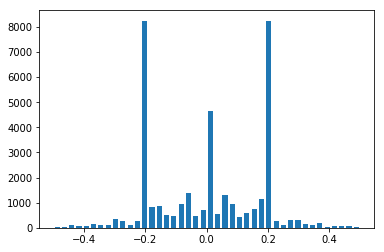

In [5]:
## Combine the two data sets - Udacity original + extra training data at the turns and it's reflections 
y_train = np.array(y_train_flipped + y_train_turns_flipped + y_train_turns.tolist() + y_train.tolist())

X_train = X_train_flipped + X_train_turns_flipped + X_train_turns + X_train
X_train = np.array(X_train)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Print sample set dimensions of input data read
print ('Image dataframe shape = ', df_train_n_images.values.shape)
print ('X_train.shape = ', X_train.shape)
print ('len(X_train) = ', len(X_train))
print ('y_train.shape = ', y_train.shape)
print ('len(y_train) = ', len(y_train))
print ('X_valid.shape = ', X_valid.shape)
print ('len(X_valid) = ', len(X_valid))
print ('y_valid.shape = ', y_valid.shape)
print ('len(y_valid) = ', len(y_valid))

import matplotlib.pyplot as plt
hist, bins = np.histogram(y_train, bins='auto',range=(-0.5,0.5))
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

## Preprocess the Data

Perform the following pre-processing via a generator
  1. Normalize the features using Min-Max scaling between -0.5 and 0.5
  2. Perform brightness adjustment before normalizing data.
  3. Flip the inputs along the vertical axis and update angle accordingly to generate balanced data.
  4. Remove bias towards 0 values by dropping data below a random threshold after adding a static bias offset


### Normalize the features

In [6]:
# Normalize the data features using Min-Max scaling
def normalize_min_max(image):
    a = -0.5
    b = 0.5
    image_min = image.min()
    image_max = image.max()
    return a + (((image - image_min) * (b - a))/ (image_max - image_min))

### Add brightness adjustment, flip along y-axis and remove bias towards 0 angles

In [13]:
import random
from sklearn.utils import shuffle

STATIC_BIAS = 0.1
TRANSLATION_X_RANGE = 99
TRANSLATION_Y_RANGE = 0.3

X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

# Generate random brightness function, produce darker transformation 
def brightness(image):
    #Convert 2 HSV colorspace from RGB colorspace
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    #Generate new random brightness
    rand = random.uniform(0.5,1.0)
    hsv[:,:,2] = rand * hsv[:,:,2]
    #Convert back to RGB colorspace
    new_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return new_image

# Horizontal translation to left/right to generate more data for non-trivial steering predictions
def horizontal_translation(image, pixels):
    (rows,cols, channels) = image.shape
    M = np.float32([[1,0,pixels],[0,1,0]])
    dst = cv2.warpAffine(image,M,(cols,rows))
    return dst

# Data generator to produce data based on random choice, thus inherently shuffling the data.
def myTrainGenerator(batch_size):
    k = 0
    while 1:
        print ("\n")
        k = k + 1
        print ('iteration= ', k)
        i = 0
        # Initialize batches of input data
        batch_X = np.zeros((batch_size, 66, 200, 3), dtype = np.float32)
        batch_y = np.zeros((batch_size,), dtype = np.float32)
        while (i < batch_size):
            choice = np.random.choice(len(X_train))
            batch_X[i] = brightness(X_train[choice])            
            batch_X[i] = normalize_min_max(batch_X[i])
            batch_y[i] = y_train[choice]

            # Remove bias towards small angles with a bias term and threshold, by reselecting
            threshold = np.random.uniform(0.1,0.2)
            if ((abs(batch_y[i]) + STATIC_BIAS) < threshold):
                choice = np.random.choice(len(X_train))
                batch_X[i] = brightness(X_train[choice])            
                batch_X[i] = normalize_min_max(batch_X[i])
                batch_y[i] = y_train[choice]
            # Apply horizontal translation to low steering angles (< 0.1) to 70% of qualified images
            translate_prob = np.random.uniform(0,1)
            if (abs(batch_y[i]) < 0.1 and translate_prob >= 0.3):
                angle = np.random.uniform(0,1)
                pixels = int((TRANSLATION_X_RANGE * angle)/TRANSLATION_Y_RANGE)
                if (batch_y[i] > 0):
                    # If steering angle is tending to the right, translate image to the right
                    # and decrease right steering to recover and be on the track
                    batch_X[i] = horizontal_translation(batch_X[i], pixels)
                    batch_y[i] = batch_y[i] - angle
                else:
                    # If steering angle is tending to the left, translate image to the left
                    # and decrease left steering to recover and be on the track
                    batch_X[i] = horizontal_translation(batch_X[i], -pixels)
                    batch_y[i] = batch_y[i] + angle
            i = i + 1
        yield (batch_X, batch_y)


def myValidationGenerator(X_validation, y_validation, batch_size):
    while 1:
        X_val, y_val = shuffle(X_validation, y_validation)
        batch_X = np.zeros((batch_size, 66, 200, 3), dtype = np.float32)
        batch_y = np.zeros((batch_size,), dtype = np.float32)
        i = 0         
        for i in range(batch_size):
            choice = np.random.choice(len(X_val))
            batch_X[i] = X_val[choice]
            batch_X[i] = brightness(X_val[choice])  
            batch_X[i] = normalize_min_max(batch_X[i])
            batch_y[i] = y_val[choice]
        yield (batch_X, batch_y)

print('Validation data generated and normalized')

Validation data generated and normalized


## Keras Layers
We'll be using the layers of Keras to build our network, such as convolution, activation, fully connected, etc.  A layer can be added to the model using the model's `add()` function.  Here is a network based on NVIDIA's paper
https://arxiv.org/pdf/1604.07316v1.pdf

## Build a Multi-Layer Network following NVIDIA architecture

Build a multi-layer feedforward neural network to predict steering angles, using the NVIDIA architecture.

1. Set the first layer to a `Convolution2D` layer with 5x5 kernel, `input_shape` set to (66, 200, 3) and `subsample` to (1,1)
2. Use a `MaxPooling2D` layer that subsamples by (2,2) after the previous convolution.
3. Use a `Dropout` layer at 0.5 dropout, following the pooling layer.
4. Use a `ReLU` activation function after the Dropout layer.
5. Set the fifth layer to a `Convolution2D` layer with 5x5 kernel, `valid` padding and `subsample` set to (2,1). The input shape from the previous operations result in (w,h)=(31,98)
6. Use a `MaxPooling2D` layer that `subsamples` by (1,2) after the previous convolution in the fifth layer.
7. Use a `Dropout` layer at 0.5 dropout, following the pooling layer.
8. Use a `ReLU` activation function after the Dropout layer.
9. Set the ninth layer to a `Convolution2D` layer with 5x5 kernel, `valid` padding and `subsample` set to (1,2). The input shape from the previous operations result in (w,h)=(14,47)
10. Use a `MaxPooling2D` layer that `subsamples` by (2,1) after the previous convolution.
11. Use a `Dropout` layer at 0.5 dropout, following the pooling layer.
12. Use a `ReLU` activation function after the Dropout layer.
13. Set the thirteenth layer to a `Convolution2D` layer with 3x3 kernel, `valid` padding and `subsample` set to (1,1).  The input shape from the previous operations result in (w,h)=(5,22)
14. Use a `ReLU` activation function after the convolution layer.
15. Set the fifteenth layer to a `Convolution2D` layer with 3x3 kernel, `valid` padding and `subsample` set to (1,1).  The input shape from the previous operations result in (w,h)=(3,20)
16. Use a `ReLU` activation function after the previous convolution.
17. Set the seventeenth layer to a `Flatten` layer with the `input_shape` set to (1, 18, 64), which flattens it to output 1152 neurons.
18. Feed the flattened output to a `Dense` layer width to 100 output neurons.
19. Use a `ReLU` activation function after the Dense layer output.
20. Set the twentieth layer to `Dense` layer width to 50 output neurons. 
21. Use a `ReLU` activation function after the above Dense layer.
22. Set the twenty-second layer to `Dense` layer width to 10 output neurons. 
23. Use a `ReLU` activation function after the previous Dense layer.
24. Set the final layer to `Dense` layer width to 1 output neuron.


## Network with Dropout
1. Construct the network with Dropout, as the network tends to be overfit with large amounts of training and augmented data.
2. Add a dropout layers after the pooling layers. Set the dropout rate to 50%.

In [14]:
# Construct the network and add dropout after the pooling layer.
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU

model = Sequential()
model.add(Convolution2D(24, 5, 5, border_mode='valid', subsample=(1,1), input_shape=(66, 200, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Activation('relu'))

# Input size (w,h)=(31,98)
model.add(Convolution2D(36, 5, 5, border_mode='valid', subsample=(2,1)))
model.add(MaxPooling2D((1, 2)))
model.add(Dropout(0.5))
model.add(Activation('relu'))

# Input size (w,h)=(14,47)
model.add(Convolution2D(48, 5, 5, border_mode='valid', subsample=(1,2)))
model.add(MaxPooling2D((2, 1)))
model.add(Dropout(0.5))
model.add(Activation('relu'))

# Input size (w,h)=(5,22)
model.add(Convolution2D(64, 3, 3, border_mode='valid', subsample=(1,1)))
model.add(Activation('relu'))

# Input size (w,h)=(3,20)
model.add(Convolution2D(64, 3, 3, border_mode='valid', subsample=(1,1)))
model.add(Activation('relu'))

# Flatten the input to 64*1*18 = 1152 neurons
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dense(1))

print ('Network created')

Network created


## Train the Network

1. Compile the network using adam optimizer and MSE loss function.
2. Train the network for 7 epochs to avoid underfitting and to get better loss as the training data is augmented.

In [15]:
# Compile and train the model
model.compile(optimizer='adam', loss='mse')
model.summary()

nb_epoch_total = 7
batch_size = 256

training_generator = myTrainGenerator(batch_size)
validation_generator = myValidationGenerator(X_valid, y_valid, batch_size)

history = model.fit_generator(training_generator,
                              samples_per_epoch=len(X_train),
                              nb_epoch=nb_epoch_total,
                              validation_data=validation_generator,
                              nb_val_samples=len(X_valid))

print('Training completed')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_11 (Convolution2D) (None, 62, 196, 24)   1824        convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
maxpooling2d_7 (MaxPooling2D)    (None, 31, 98, 24)    0           convolution2d_11[0][0]           
____________________________________________________________________________________________________
dropout_7 (Dropout)              (None, 31, 98, 24)    0           maxpooling2d_7[0][0]             
____________________________________________________________________________________________________
activation_17 (Activation)       (None, 31, 98, 24)    0           dropout_7[0][0]                  
___________________________________________________________________________________________

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


36864/36832 [==============================] - 68s - loss: 0.0549 - val_loss: 0.0213
Epoch 2/7


iteration=  155
  256/36832 [..............................] - ETA: 63s - loss: 0.0322

iteration=  156
  512/36832 [..............................] - ETA: 63s - loss: 0.0395

iteration=  157
  768/36832 [..............................] - ETA: 62s - loss: 0.0435

iteration=  158
 1024/36832 [..............................] - ETA: 62s - loss: 0.0435

iteration=  159
 1280/36832 [>.............................] - ETA: 61s - loss: 0.0426

iteration=  160
 1536/36832 [>.............................] - ETA: 61s - loss: 0.0432

iteration=  161
 1792/36832 [>.............................] - ETA: 60s - loss: 0.0422

iteration=  162
 2048/36832 [>.............................] - ETA: 60s - loss: 0.0429

iteration=  163
 2304/36832 [>.............................] - ETA: 59s - loss: 0.0439

iteration=  164
 2560/36832 [=>............................] - ETA: 59s - loss: 0.0455

iteration=  165
 2816/3

# Save the model and weights

Model architecture to be saved in model.json

Model weights to be saved in model.h5

OR

Model architecture and weights compiled and saved in model.h5

In [16]:
# serialize model to JSON
#model_json = model.to_json()
#with open("model.json", "w") as json_file:
    #json_file.write(model_json)

# serialize weights to HDF5
#model.save_weights("model.h5")

# serialize compiled model arch and weights in HDF5
model.save('model.h5') 
print("Saved model to disk")

Saved model to disk
